In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_prepared.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


## Podział

In [4]:
df.columns

Index(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       'tAlivePlayers', 'tEqVal', 'bombsite', 'ct_hp', 't_hp', 'ct_armor',
       't_armor', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_

In [5]:
def select_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 'ct_mainWeapon_Others',
       't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle',
       't_mainWeapon_Others', 'ct_secondaryWeapon_Pistol',
       'ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'de_ancient',
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

In [6]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')

df_train, df_test = df.loc[~filtr], df.loc[filtr]

In [7]:
match_map = df_train.groupby(['filename', 'mapName']).indices
len(match_map.keys())

299

In [8]:
maps = len(match_map.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.9*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(match_map):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, match_map[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, match_map[key]))

train_indexes.shape

(2594070,)

In [9]:
maps = len(match_map.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.9*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(match_map):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, match_map[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, match_map[key]))

train_indexes.shape

(2594070,)

In [10]:
df_valid = df_train.iloc[valid_indexes]
df_valid['winningSideCT'].value_counts(normalize=True)

1    0.524193
0    0.475807
Name: winningSideCT, dtype: float64

In [11]:
df_train = df_train.iloc[train_indexes]
df_train['winningSideCT'].value_counts(normalize=True)

1    0.523806
0    0.476194
Name: winningSideCT, dtype: float64

In [12]:
df_test['winningSideCT'].value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [13]:
def generate_indices(data, lookback):
    grouped = data.groupby(['matchID', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(data.index), lookback), dtype=np.int32)
    for key in dict_gr:
        minimum, maximum = dict_gr[key]
        for i in range(minimum, maximum + 1):
            if i - minimum < lookback:
                indices[i] = np.hstack((np.repeat(-1, lookback - (i + 1 - minimum)), np.arange(minimum, i + 1, dtype=np.int32)))
            else:
                indices[i] = np.arange(i + 1 - lookback, i + 1, dtype=np.int32)
    return indices

In [14]:
lookback = 20
train_indexes = generate_indices(df_train, lookback)
valid_indexes = generate_indices(df_valid, lookback)
test_indexes = generate_indices(df_test, lookback)

In [15]:
train_indexes.size * train_indexes.itemsize / 1_000_000, valid_indexes.size * valid_indexes.itemsize / 1_000_000 , test_indexes.size * test_indexes.itemsize / 1_000_000

(207.5256, 23.42528, 23.94808)

In [16]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_valid['winningSideCT'], df_test['winningSideCT']
norm_train, norm_valid, norm_test = select_feat(df_train), select_feat(df_valid), select_feat(df_test)
cols = norm_train.columns.tolist()
del df_train, df_valid, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [17]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [18]:
train_seq = CSGOsequence(norm_train, y_train.values, 2048, train_indexes, shuffle=True)
valid_seq = CSGOsequence(norm_valid, y_valid.values, 2048, valid_indexes, shuffle=False)
test_seq = CSGOsequence(norm_test, y_test.values, 2048, test_indexes, shuffle=False)

In [19]:
os.makedirs("model_deep", exist_ok=True)

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/rnn.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/rnn_log.csv", separator=',', append=True
)

In [21]:
model = Sequential()
model.add(InputLayer(input_shape=(lookback, norm_train.shape[-1])))
model.add(Masking(mask_value=0.))
model.add(GRU(256, kernel_regularizer='l2', recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2', dropout=0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(train_seq,
                    epochs=200,
                    validation_data=valid_seq,
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/200
1267/1267 [==============================] - 131s 100ms/step - loss: 0.6956 - binary_accuracy: 0.7602 - auc: 0.8537 - val_loss: 0.5561 - val_binary_accuracy: 0.7506 - val_auc: 0.8513


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 2/200
1267/1267 [==============================] - 125s 99ms/step - loss: 0.5532 - binary_accuracy: 0.7612 - auc: 0.8549 - val_loss: 0.5566 - val_binary_accuracy: 0.7448 - val_auc: 0.8508
Epoch 3/200
1267/1267 [==============================] - 126s 100ms/step - loss: 0.5532 - binary_accuracy: 0.7618 - auc: 0.8552 - val_loss: 0.5548 - val_binary_accuracy: 0.7548 - val_auc: 0.8542


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 4/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5533 - binary_accuracy: 0.7616 - auc: 0.8552 - val_loss: 0.5557 - val_binary_accuracy: 0.7517 - val_auc: 0.8536
Epoch 5/200
1267/1267 [==============================] - 126s 100ms/step - loss: 0.5534 - binary_accuracy: 0.7617 - auc: 0.8553 - val_loss: 0.5559 - val_binary_accuracy: 0.7460 - val_auc: 0.8521
Epoch 6/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5534 - binary_accuracy: 0.7615 - auc: 0.8552 - val_loss: 0.5534 - val_binary_accuracy: 0.7518 - val_auc: 0.8561


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 7/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5534 - binary_accuracy: 0.7615 - auc: 0.8552 - val_loss: 0.5559 - val_binary_accuracy: 0.7477 - val_auc: 0.8517
Epoch 8/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5534 - binary_accuracy: 0.7615 - auc: 0.8552 - val_loss: 0.5552 - val_binary_accuracy: 0.7566 - val_auc: 0.8542
Epoch 9/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5533 - binary_accuracy: 0.7616 - auc: 0.8553 - val_loss: 0.5557 - val_binary_accuracy: 0.7502 - val_auc: 0.8539
Epoch 10/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5535 - binary_accuracy: 0.7614 - auc: 0.8551 - val_loss: 0.5581 - val_binary_accuracy: 0.7450 - val_auc: 0.8506
Epoch 11/200
1267/1267 [==============================] - 126s 99ms/step - loss: 0.5533 - binary_accuracy: 0.7617 - auc: 0.8552 - val_loss: 0.5558 - val_binary_accuracy: 0.7507 - val_auc: 0.8523
Epoch 12/200
1267/1267 [====

INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 24/200
1267/1267 [==============================] - 124s 98ms/step - loss: 0.5534 - binary_accuracy: 0.7615 - auc: 0.8552 - val_loss: 0.5543 - val_binary_accuracy: 0.7487 - val_auc: 0.8528
Epoch 25/200
1267/1267 [==============================] - 124s 98ms/step - loss: 0.5532 - binary_accuracy: 0.7616 - auc: 0.8553 - val_loss: 0.5566 - val_binary_accuracy: 0.7493 - val_auc: 0.8529
Epoch 26/200
1267/1267 [==============================] - 124s 98ms/step - loss: 0.5535 - binary_accuracy: 0.7615 - auc: 0.8551 - val_loss: 0.5552 - val_binary_accuracy: 0.7472 - val_auc: 0.8526
Epoch 27/200
1267/1267 [==============================] - 135s 106ms/step - loss: 0.5533 - binary_accuracy: 0.7616 - auc: 0.8552 - val_loss: 0.5561 - val_binary_accuracy: 0.7472 - val_auc: 0.8528
Epoch 28/200
1267/1267 [==============================] - 133s 105ms/step - loss: 0.5532 - binary_accuracy: 0.7615 - auc: 0.8553 - val_loss: 0.5555 - val_binary_accuracy: 0.7499 - val_auc: 0.8530
Epoch 29/200
1267/1267 

INFO:tensorflow:Assets written to: models/model.tf\assets


INFO:tensorflow:Assets written to: models/model.tf\assets


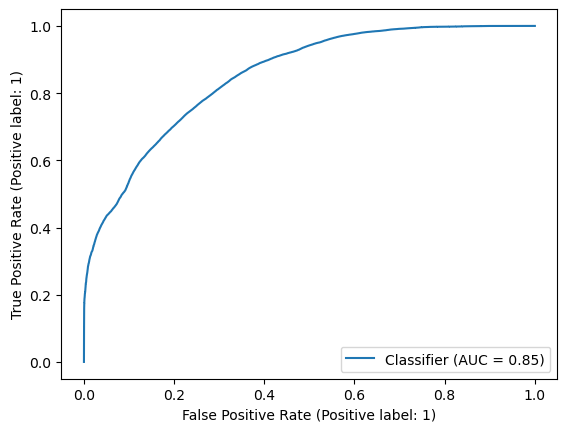

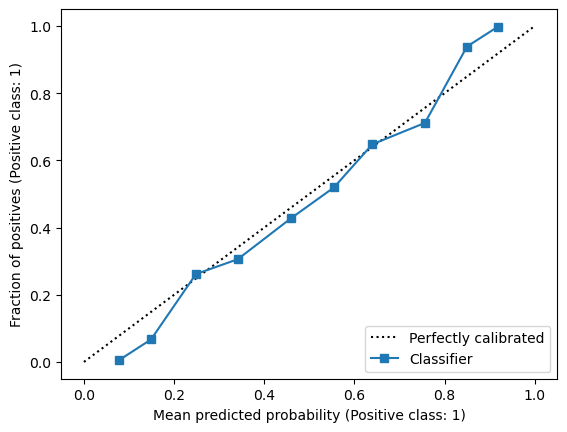

In [22]:
run_name = "RNN - test"
additional_description = "RNN"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)
        mlflow.log_param("Sequence", lookback)

        y_proba = model.predict(test_seq)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")